In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as ss
import scipy.integrate as si
import scipy.optimize as so
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnl
jax.config.update("jax_enable_x64", True)

In [2]:
# size of spatial domain
a = 10.0

# set number of real space grid points for plotting
numx = 1025
# spatial grid for the purposes of plotting
xvec = np.linspace(-a, a, numx)

# set number of Fourier basis functions
# basis functions will be N = -numfour to N = numfour
numfour = 32

# matrix for converting Fourier basis coefficients
# to real space values
fourNvec = np.arange(-numfour, numfour + 1)
fourtox = np.exp(1j * np.pi * np.outer(fourNvec, xvec) / a) / np.sqrt(2 * a)

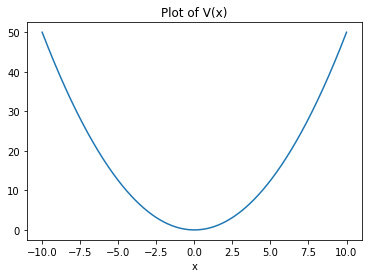

In [3]:
# define potential for generating training data

def v(x):
    # harmonic potential
    return 0.5 * x**2

# compute true potential on real space grid for plotting
vxvec = v(xvec)

# plot true potential
plt.plot(xvec, vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

In [4]:
# transform real space potential to Fourier
# representation using quadrature method
# (in tdse-adj-cheb-fft-vs-quad-kbc.ipynb we show that
# the quadrature method produces much more accurate
# results than the FFT method)

vtoeprow = []
for thisN in range(2 * numfour +1):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisN * x / a) / (2 * a)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    vtoeprow.append(si.quad(rintgrnd, -a, a)[0] + 1j * si.quad(iintgrnd, -a, a)[0])
vtoeprow = np.array(vtoeprow)
fourvmat = sl.toeplitz(r=vtoeprow, c=vtoeprow.conj())

print('Shape fourvmat:', fourvmat.shape)

Shape fourvmat: (65, 65)


L2 Error psi0_0: 4.072507283500841e-06
L-infinity Error psi0_0: 1.8301527573114097e-06
L2 Error psi0_1: 4.072507283500477e-06
L-infinity Error psi0_1: 1.8301527573114097e-06


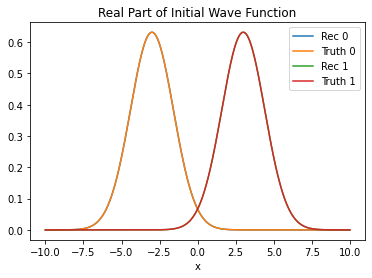

In [5]:
# define initial states and transform to Fourier
# representation

def psi0_1(x):
    return np.exp(-(x + 3)**2 / 4) * (2.0 / np.pi)**0.25

# compute psi0_1 normalization
psi0_1_prob_intgrnd = lambda x: np.abs(psi0_1(x))**2
psi0_1_norm = np.sqrt(si.quad(psi0_1_prob_intgrnd, -a, a)[0])

# normalized psi0_1 function
def norm_psi0_1(x):
    return psi0_1(x)/psi0_1_norm

# transform normed psi0_1 to Fourier representation
norm_psi0_1_quad = np.zeros(numfour + 1, dtype=np.complex128)
for thisn in range (numfour + 1):
    def intgrnd(x):
        return norm_psi0_1(x) * np.exp(-1j * np.pi * thisn * x / a) / np.sqrt(2 * a)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    norm_psi0_1_quad[thisn] = si.quad(rintgrnd, -a, a)[0] + 1j * si.quad(iintgrnd, -a, a)[0]

a0_1 = np.concatenate([np.conjugate(np.flipud(norm_psi0_1_quad[1:])), norm_psi0_1_quad])

def psi0_2(x):
    return np.exp(-(x - 3)**2 / 4) * (2.0 / np.pi)**0.25

# compute psi0_1 normalization
psi0_2_prob_intgrnd = lambda x: np.abs(psi0_2(x))**2
psi0_2_norm = np.sqrt(si.quad(psi0_2_prob_intgrnd, -a, a)[0])

# normalized psi0_1 function
def norm_psi0_2(x):
    return psi0_2(x)/psi0_2_norm

# transform normed psi0_1 to Fourier representation
norm_psi0_2_quad = np.zeros(numfour + 1, dtype=np.complex128)
for thisn in range (numfour + 1):
    def intgrnd(x):
        return norm_psi0_2(x) * np.exp(-1j * np.pi * thisn * x / a) / np.sqrt(2 * a)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    norm_psi0_2_quad[thisn] = si.quad(rintgrnd, -a, a)[0] + 1j*si.quad(iintgrnd, -a, a)[0]

a0_2 = np.concatenate([np.conjugate(np.flipud(norm_psi0_2_quad[1:])), norm_psi0_2_quad])

a0vec = []
a0vec.append(a0_1)
a0vec.append(a0_2)

norm_psi0_vec = []
norm_psi0_vec.append(norm_psi0_1(xvec))
norm_psi0_vec.append(norm_psi0_2(xvec))

norm_psi0_rec_vec = []
norm_psi0_rec_vec.append(a0_1 @ fourtox)
norm_psi0_rec_vec.append(a0_2 @ fourtox)

# plot real part of the normalized psi0
for i in range(2):
    print(f'L2 Error psi0_{i}:', nl.norm(norm_psi0_vec[i] - norm_psi0_rec_vec[i]))
    print(f'L-infinity Error psi0_{i}:', np.max(np.abs(norm_psi0_vec[i] - norm_psi0_rec_vec[i])))
    plt.plot(xvec, norm_psi0_rec_vec[i].real, label=f"Rec {i}")
    plt.plot(xvec, norm_psi0_vec[i].real, label=f"Truth {i}")

plt.title('Real Part of Initial Wave Function')
plt.xlabel('x')
plt.legend()
plt.show()

In [6]:
# solve the forward TDSE problem in the Fourier
# representation

# set time-step size
dt = 1e-2

# set number of time-steps
# size of trajectory = numts + 1
numts = 100

# kinetic operator in the Fourier representation
kmat = np.diag(np.arange(-numfour, numfour + 1)**2 * np.pi**2 / (2 * a**2))

# Hamiltonian operator in the Fourier representation
fourHmat = kmat + fourvmat

# check if the Hamiltonian matrix is Hermitian
print('fourHmat Hermitian check (should be close to zero):', nl.norm(fourHmat - fourHmat.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
fourspc, fourstt = nl.eigh(fourHmat)

# check if eigendecomposition diagonalizes the
# Hamiltonian matrix
# if result is close to zero then
# fourHmat = fourstt @ np.diag(fourspc) @ np.conj(fourstt).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(fourHmat @ fourstt - fourstt @ np.diag(fourspc)), sep='\n')

# check if eigenstates are unitary
print('Check if fourstt is unitary (should be close to zero):', nl.norm(fourstt @ fourstt.T.conj() - np.eye(2 * numfour + 1)), sep='\n')

# compute propagator matrix
fourpropa = fourstt @ np.diag(np.exp(-1j * fourspc * dt)) @ fourstt.conj().T

fouramatvec = []

# propagate "a" state
for thisa0 in a0vec:
    tempfouramat = np.zeros((numts + 1, 2 * numfour + 1), dtype=np.complex128)
    tempfouramat[0] = thisa0.copy()
    for i in range(numts):
        tempfouramat[i + 1] = fourpropa @ tempfouramat[i]
    fouramatvec.append(tempfouramat)

jaxfouramatvec = jnp.stack(fouramatvec)

print('Done propagating')
print('Shape jaxfouramatvec:', jaxfouramatvec.shape)

fourHmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
3.392077258042753e-13
Check if fourstt is unitary (should be close to zero):
1.2469110651416776e-14
Done propagating
Shape jaxfouramatvec: (2, 101, 65)


In [7]:
# Jax compliant method for making a toeplitz matrix

numtoepelm = 2 * numfour + 1
aa = (-1) * np.arange(0, numtoepelm).reshape(numtoepelm, 1)
bb = [np.arange(numtoepelm - 1, 2 * numtoepelm -1)]
toepindxmat = jnp.array(aa + bb)
print(toepindxmat.shape)

(65, 65)


In [8]:
# Chebyshev Representation

# set number of Chebyshev basis functions
# I have found odd numbers work best
numcheb = 11

# compute Chebyshev coefficients for true potential
def theta(k):
    return (k - 0.5) * np.pi / (numcheb + 1)

def g(k):
    return v(a * np.cos(theta(k)))

chebkvec = np.arange(1, numcheb + 2)
chebnvec = np.arange(0, numcheb + 1)

chebweights = np.ones(numcheb + 1)
chebweights[0] = 0.5

chebvcff = 2 / (numcheb + 1) * np.sum(g(chebkvec) * np.cos(chebnvec[..., np.newaxis] * theta(chebkvec)), axis=1)

chebvcff = chebweights * chebvcff

print('chebvcff:', chebvcff, sep='\n')

# matrix for converting cheb to real space
chebtox = ss.eval_chebyt(np.expand_dims(chebnvec, 0), np.expand_dims(xvec / a, 1))

# matrix for converting cheb to four
chebtofour = []

for thiscn in range(numcheb + 1):
    temptoeprow = []
    # convert cheb basis function to four representation
    for thisn in range(2 * numfour + 1):
        def intgrnd(x):
            return ss.eval_chebyt(thiscn, x / a) * np.exp(-1j * np.pi * thisn * x / a) / (2 * a)

        def rintgrnd(x):
            return intgrnd(x).real

        def iintgrnd(x):
            return intgrnd(x).imag

        temptoeprow.append(si.quad(rintgrnd, -a, a)[0] + 1j * si.quad(iintgrnd, -a, a)[0])
    chebtofour.append(sl.toeplitz(r=temptoeprow, c=np.conj(temptoeprow)))

jaxchebtofour = jnp.array(chebtofour).T

print('Shape chebtoF:', jaxchebtofour.shape)

chebvcff:
[ 2.50000000e+01  4.73695157e-15  2.50000000e+01  3.55271368e-15
 -9.47390314e-15  2.13162821e-14 -5.92118946e-15  1.42108547e-14
 -1.06581410e-14  1.65793305e-14 -3.43428989e-14  2.13162821e-14]
Shape chebtoF: (65, 65, 12)


In [9]:
def cobjfn(cffs):
    vhatmat = jaxchebtofour @ cffs
    # print('L2 Error vmat (should be close to 0):', jnpl.norm(vmat - cvmat), sep='\n')

    # construct the Hamiltonian matrix
    hhatmat = kmat + vhatmat
    # print('L2 Error hmat (should be close to 0):', jnpl.norm(hmat - chmat), sep='\n')

    # eigendecomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hhatmat)
    # print('L2 Error spc (should be close to 0):', jnpl.norm(spc - cspc), sep='\n')
    # print('L2 Error stts (should be close to 0):', jnpl.norm(stts - cstts), sep='\n')

    # compute the propagator matrix using the
    # result of the eigendecomposition
    propahatmat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T
    # print('L2 Error propamat (should be close to 0):', jnpl.norm(propamat - cpropa), sep='\n')

    ahatmatvec = []
    # propagate the system starting from the initial "a" state
    for thisa0 in a0vec:
        tempamat = [thisa0.copy()]
        for i in range(numts):
            tempamat.append(propahatmat @ tempamat[i])
        # make python list a jax object
        ahatmatvec.append(jnp.stack(tempamat))
    # make python list a jax object
    ahatmatvec = jnp.stack(ahatmatvec)

    # compute the sum of objective functions in one line
    residue = ahatmatvec - jaxfouramatvec
    objective = jnp.sum(0.5 * jnp.real(jnp.sum(jnp.conj(residue) * residue, axis=1)))

    return objective

jitcobjfn = jax.jit(cobjfn)
print('jitcobjfn(chebvcff):', jitcobjfn(chebvcff))

jitcobjfn(chebvcff): 1.7469457069175927e-24


In [10]:
def adjhelper(cffs):
    vhatmat = jaxchebtofour @ cffs
    # print('L2 Error vmat (should be close to 0):', jnpl.norm(vmat - cvmat), sep='\n')

    # construct the Hamiltonian matrix
    hhatmat = kmat + vhatmat
    # print('L2 Error hmat (should be close to 0):', jnpl.norm(hmat - chmat), sep='\n')

    # eigendecomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hhatmat)
    # print('L2 Error spc (should be close to 0):', jnpl.norm(spc - cspc), sep='\n')
    # print('L2 Error stts (should be close to 0):', jnpl.norm(stts - cstts), sep='\n')

    # propagator of a states
    propahatmat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T
    # print('L2 Error propamat (should be close to 0):', jnpl.norm(propamat - cpropa), sep='\n')

    # backwards in time propagator of lmat
    proplmat = stthat @ jnp.diag(jnp.exp(1j * spchat * dt)) @ stthat.conj().T

    ahatmatvec = []
    lmatvec = []

    # propagate the system starting from the initial "a" state
    for i in range(len(jaxfouramatvec)):
        tempamat = [a0vec[i].copy()]
        for j in range(numts):
            tempamat.append(propahatmat @ tempamat[j])
        # make python list a jax object
        ahatmatvec.append(jnp.stack(tempamat))

        # propagate the "lambda" vector of coefficients backward
        # in time, i.e., solve the adjoint problem
        templmat = [ahatmatvec[-1][numts,:] - jaxfouramatvec[i][numts,:]]
        # itr = 0 # forward evaluation of lmat
        for j in range(numts - 1, 0 - 1, -1):
            templmat.append(ahatmatvec[-1][j,:] - jaxfouramatvec[i][j] + proplmat @ templmat[numts - 1 - j] )

        # make python list a jax object
        lmatvec.append(jnp.flipud(jnp.stack(templmat)))

    # make python list a jax object
    ahatmatvec = jnp.stack(ahatmatvec)
    lmatvec = jnp.stack(lmatvec)

    offdiagmask = jnp.ones((numtoepelm, numtoepelm)) - jnp.eye(numtoepelm)
    expspec = jnp.exp(-1j * dt * spchat)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spchat, spchat)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(numtoepelm)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)

    derivamats = jnp.einsum('ij,jkm,kl->ilm', stthat.conj().T, jaxchebtofour, stthat) * jnp.expand_dims(mask, 2)
    # print('sttshat.conj().T.shape', sttshat.conj().T.shape)
    alldmatreal = -1j * dt * jnp.einsum('ij,jkm,kl->mil', stthat, derivamats, stthat.conj().T)

    derivamats = jnp.einsum('ij,jkm,kl->ilm', stthat.conj().T, jaxchebtofour, stthat) * jnp.expand_dims(mask, 2)
    alldmatimag = -1j * dt * jnp.einsum('ij,jkm,kl->mil', stthat, derivamats, stthat.conj().T)

    alldmat = jnp.vstack([alldmatreal, alldmatimag])
    # print('Shape alldmat', alldmat.shape)

    return ahatmatvec, lmatvec, alldmat

def cgradfn(cffs):
    ahatmatvec, lmatvec, alldmat = adjhelper(cffs)
    # compute all entries of the gradient at once
    gradients = jnp.einsum('bij,ajk,bik->a', jnp.conj(lmatvec[:, 1:, :]), alldmat, ahatmatvec[:, :-1, :]).real[:numcheb + 1]
    return gradients

print('Shape cgradfn(cvec):', cgradfn(chebvcff).shape)

print('Gradients for True Chebyshev Coefficients (should be close to 0):', cgradfn(chebvcff), sep='\n')

jitcgradfn = jax.jit(cgradfn)
print('jitcgradfn(cvec):', jitcgradfn(chebvcff), sep='\n')

Shape cgradfn(cvec): (12,)
Gradients for True Chebyshev Coefficients (should be close to 0):
[-2.13130812e-15  3.35740797e-13  5.67928905e-15 -8.43207550e-13
 -3.44864030e-14  9.41946393e-13  1.32727703e-13 -5.95080227e-13
 -3.29951571e-13 -1.18811991e-14  5.75527379e-13  5.79384266e-13]
jitcgradfn(cvec):
[ 6.97350034e-15  3.28132341e-13  1.56478854e-14 -8.22287342e-13
 -8.39718597e-14  9.12586389e-13  2.04365185e-13 -5.63222483e-13
 -3.80465223e-13 -4.07077637e-14  5.68001717e-13  6.00233410e-13]


In [11]:
randcffvec = []
numitervec = []
resrandcffvec = []
randcffvecL2 = []
randcffvecLinf = []

for i in range(100):
    randcffvec.append(np.random.default_rng().uniform(low=-5.0, high=5.0, size=numcheb + 1))
    tempresults = so.minimize(jitcobjfn, randcffvec[-1], jac=jitcgradfn, tol=1e-15, options={'maxiter': 1000, 'disp': False, 'gtol': 1e-14})
    numitervec.append(tempresults.nit)
    if (i + 1) % 10 == 0:
        print(f'{i + 1}, Number of iterations:', numitervec[-1])
    resrandcffvec.append(tempresults.x)

    randcffvecL2.append(nl.norm(chebtox @ resrandcffvec[-1] - vxvec))
    # print('Vector L2 Norm of Potential:', nl.norm(chebtox @ resrandcffvec[-1] - vxvec), sep='\n')

    randcffvecLinf.append(np.max(np.abs(chebtox @ resrandcffvec[-1] - vxvec)))
    # print('Vector L-infinity Norm of Potential:', np.max(np.abs(chebtox @ resrandcffvec[-1] - vxvec)), sep='\n')

    # plot learned vs true
    # plt.plot(xvec, chebtox @ randcff, label='Rand initial')
    # plt.plot(xvec, chebtox @ resrandcffvec[-1], label='Last learned')
    # plt.plot(xvec, vxvec, label='Truth')
    # plt.title('Learned Potential vs. Truth')
    # plt.legend()
    # plt.show()

print('Average number of iterations:', np.mean(numitervec))
print('Max number of iterations:', np.max(numitervec))
print('Average of randcffvecL2:', np.mean(randcffvecL2))
print('Max of randcffvecL2:', np.max(randcffvecL2))
print('Average of randcffvecLinf:', np.mean(randcffvecLinf))
print('Max of randcffvecLinf:', np.max(randcffvecLinf))

10, Number of iterations: 118
20, Number of iterations: 156
30, Number of iterations: 270
40, Number of iterations: 134
50, Number of iterations: 121
60, Number of iterations: 175
70, Number of iterations: 133
80, Number of iterations: 163
90, Number of iterations: 199
100, Number of iterations: 133
Average number of iterations: 148.5
Max number of iterations: 393
Average of randcffvecL2: 1939.7994143880892
Max of randcffvecL2: 147253.820011092
Average of randcffvecLinf: 283.00135335340366
Max of randcffvecLinf: 20430.396783807715


[1.e+00 1.e-02 1.e-04 1.e-06 1.e-08 1.e-10 1.e-12]
[2, 0, 0, 0, 10, 88, 0]


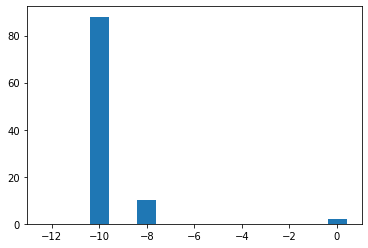

In [52]:
print(1e-1**np.arange(0, 12 + 1, 2))

randcffvecL2 = np.array(randcffvecL2)

bardata = []

bardata.append(np.count_nonzero(randcffvecL2 >= 1))

for thisbin in 1e-1**np.arange(2, 10 + 1, 2):
    bardata.append(np.count_nonzero(np.logical_and(randcffvecL2 >= thisbin, randcffvecL2 < thisbin * 1e2)))

bardata.append(np.count_nonzero(randcffvecL2 < 1e-12))

print(bardata)

# 1e-1**np.arange(0, 12 + 1, 2)
# plt.plot(-np.arange(0, 12 + 1, 2), bardata, '*')
# plt.show()

# 1e-1**np.arange(0, 12 + 1, 2)
plt.bar(-np.arange(0, 12 + 1, 2), bardata)
# plt.yscale('log')
plt.show()

In [75]:
print('Index of max:', np.argmax(randcffvecL2))
print('Value of max:', np.max(randcffvecL2))
randcffvec = np.array(randcffvec)
print('Shape randcffvec:', randcffvec.shape)
print((randcffvec[randcffvecL2 > 1]).shape)
print('Max:', np.max(randcffvec[randcffvecL2 > 1], axis=0), sep='\n')
print('Min:', np.min(randcffvec[randcffvecL2 > 1], axis=0), sep='\n')
print('Mean:', np.mean(randcffvec[randcffvecL2 > 1], axis=0), sep='\n')
print('Max:', np.max(randcffvec[np.invert(randcffvecL2 > 1)], axis=0), sep='\n')
print('Min:', np.min(randcffvec[np.invert(randcffvecL2 > 1)], axis=0), sep='\n')
print('Mean:', np.mean(randcffvec[np.invert(randcffvecL2 > 1)], axis=0), sep='\n')

Index of max: 29
Value of max: 147253.820011092
Shape randcffvec: (100, 12)
(2, 12)
Max:
[-2.92369149 -3.76307047  1.43416328  3.05049373 -0.13483443  0.73795613
  2.73736821  3.21444218  1.79364049  4.6451188  -0.86290849  1.28150433]
Min:
[-3.12988897 -4.37103908  0.07435009 -0.14831224 -4.11339549 -1.89022178
 -3.95838048  2.22612684 -1.73701154 -1.24828781 -4.137175   -4.56277328]
Mean:
[-3.02679023 -4.06705477  0.75425669  1.45109074 -2.12411496 -0.57613283
 -0.61050613  2.72028451  0.02831447  1.69841549 -2.50004174 -1.64063448]
Max:
[4.91996918 4.98873461 4.93831632 4.99557013 4.94526418 4.97356945
 4.93874762 4.96428508 4.5800741  4.82411441 4.99819868 4.92769099]
Min:
[-4.99994986 -4.93202241 -4.63100736 -4.8388271  -4.96225339 -4.80692453
 -4.98548991 -4.99118379 -4.95913739 -4.52151041 -4.9974594  -4.94164208]
Mean:
[ 0.10293817 -0.02093611  0.24677639 -0.00113286 -0.14999514  0.03010365
  0.08160113  0.02467144  0.34138272  0.1033953  -0.11060845 -0.12280406]


In [77]:
resmax = so.minimize(jitcobjfn, randcffvec[29], jac=jitcgradfn, tol=1e-15, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-14}).x

print(nl.norm(chebtox @ resmax - vxvec))

         Current function value: 77.370669
         Iterations: 270
         Function evaluations: 386
         Gradient evaluations: 374
147253.820011092


In [48]:
print('Average number of iterations:', np.mean(np.delete(numitervec, [31, 48, 58, 69])))
print('Max number of iterations:', np.max(np.delete(numitervec, [31, 48, 58, 69])))
print('Average of randcffvecL2:', np.mean(np.delete(randcffvecL2, [31, 48, 58, 69])))
print('Max of randcffvecL2:', np.max(np.delete(randcffvecL2, [31, 48, 58, 69])))
print('Average of randcffvecLinf:', np.mean(np.delete(randcffvecLinf, [31, 48, 58, 69])))
print('Max of randcffvecLinf:', np.max(np.delete(randcffvecLinf, [31, 48, 58, 69])))

Average number of iterations: 148.30208333333334
Max number of iterations: 250
Average of randcffvecL2: 4.604757956525942e-09
Max of randcffvecL2: 3.2232135675938976e-08
Average of randcffvecLinf: 9.776458901692802e-10
Max of randcffvecLinf: 6.5166787521775404e-09


In [44]:
print(np.delete(randcffvecL2, [31, 48, 58, 69]))
print(randcffvecL2[48])

3973.1042890152958
3973.1042890152958


randcffvecL2[2]:
2.206008740991127e-09
randcffvec[2]:
[-2.12875793  2.63858382 -4.06737104 -4.12788198  2.7370359   0.1987807
 -4.45953696 -1.04926802 -1.44998215 -1.40242946  1.65919345  0.07133808]


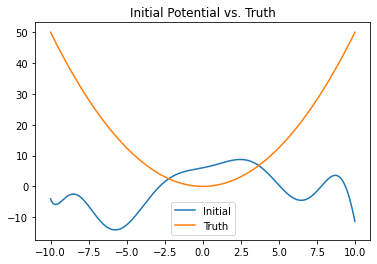

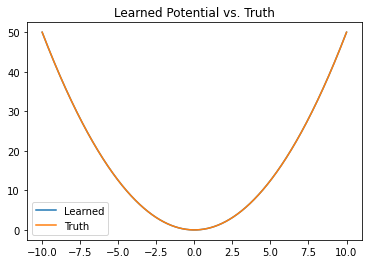

In [51]:
print('randcffvecL2[2]:', randcffvecL2[2], sep='\n')

print('randcffvec[2]:', randcffvec[2], sep='\n')

# plot inital vs true
plt.plot(xvec, chebtox @ randcffvec[2], label='Initial')
plt.plot(xvec, vxvec, label='Truth')
plt.title('Initial Potential vs. Truth')
plt.legend()
plt.show()

# plot learned vs true
plt.plot(xvec, chebtox @ resrandcffvec[2], label='Learned')
plt.plot(xvec, vxvec, label='Truth')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()